In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
import func as func  # func.py is in the same directory with this file

Download data from Binance

In [2]:
symbol = "BTCUSDT"  # code of Bitcoin
interval = "1h"  # time interval: hourly
start_date = "2025-01-01"
end_date = "2025-09-01"

df = func.get_klines(symbol, interval, start_date, end_date)  # download data
df = df[['open_time', 'close_time', 'close', 'high', 'low']]  # select fields from df
df[['close', 'high', 'low']] = df[['close', 'high', 'low']].astype(float)  # transfer the data of selected columns from str to float

df.head(5)

,open_time,close_time,close,high,low
0,2025-01-01 00:00:00,2025-01-01 00:59:59.999,94401.14,94509.42,93489.03
1,2025-01-01 01:00:00,2025-01-01 01:59:59.999,93607.74,94408.72,93578.77
2,2025-01-01 02:00:00,2025-01-01 02:59:59.999,94098.91,94105.12,93594.56
3,2025-01-01 03:00:00,2025-01-01 03:59:59.999,93838.04,94098.91,93728.22
4,2025-01-01 04:00:00,2025-01-01 04:59:59.999,93553.91,93838.04,93500.00


Compute key indicators

In [3]:
period = 14  # time interval for computing RSI and Bollinger Bands
macd_span = [12, 26, 9]  # time interval for computing MACD

df = func.compute_adx(df, period)  # compute ADX
df['RSI'] = func.compute_rsi(df['close'], period=period, ema=True)  # compute RSI
df['BB_sma'], df['BB_up'], df['BB_low'] = func.compute_bbands(
    df['close'], window=period)  # compute bollinger bands, keep window same as period of RSI
df['MACD'], df['signal'], df['histogram'] = func.compute_macd(df['close'], macd_span)  # compute MACD

df.head(5)

,open_time,close_time,close,high,low,tr1,tr2,tr3,TR,+DM,...,-DI,DX,ADX,RSI,BB_sma,BB_up,BB_low,MACD,signal,histogram
0,2025-01-01 00:00:00,2025-01-01 00:59:59.999,94401.14,94509.42,93489.03,1020.39,NaN,NaN,1020.39,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2025-01-01 01:00:00,2025-01-01 01:59:59.999,93607.74,94408.72,93578.77,829.95,7.58,822.37,829.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-63.291168,-12.658234,-50.632934
2,2025-01-01 02:00:00,2025-01-01 02:59:59.999,94098.91,94105.12,93594.56,510.56,497.38,13.18,510.56,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-72.975346,-24.721656,-48.253690
3,2025-01-01 03:00:00,2025-01-01 03:59:59.999,93838.04,94098.91,93728.22,370.69,0.00,370.69,370.69,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.541180,-39.885561,-60.655619
4,2025-01-01 04:00:00,2025-01-01 04:59:59.999,93553.91,93838.04,93500.00,338.04,0.00,338.04,338.04,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-143.658216,-60.640092,-83.018124


Exercise Strategy

In [4]:
param = {
    'capital': 10000,  # initial capital
    'position': 0.0,  # initial position
    'slippage': 0.001,
    'commision': 0.001,
    'trade_ratio': 0.2,  # 
    'adx_threshold': [20, 25],  # adx bound to classify volatile/trending market
    'rsi_threshold': [30, 70],  # rsi bound to classify oversold/overbought
    'rsi_up': [35, 75],
    'rsi_down': [25, 65],
    'bb_threshold': [0.95, 1.05]
}  # parameters of strategy

valid_index = max(df['ADX'].first_valid_index(), df['RSI'].first_valid_index())  # find the first index of line where all indicators are not nan
df = df[df.index >= valid_index].reset_index(drop=True)  # start from the first line that all indicators are not nan

trades, account = func.strategy(df, param)  # exercise strategy and use [trades, account] to record
print(trades.tail(5))
print(account.tail(5))

100%|██████████| 5807/5807 [00:01<00:00, 2917.72it/s]

                       time  side         price    amount  stop
122 2025-08-22 17:59:59.999  sell  116906.97600  0.108120     0
123 2025-08-24 19:59:59.999   buy  112712.60000  0.022406     0
124 2025-08-24 20:59:59.999   buy  112883.16039  0.022370     0
125 2025-08-25 19:59:59.999   buy  110826.84613  0.022610     0
126 2025-08-30 02:59:59.999   buy  107889.79201  0.022851     0
                        time      price  position         cash
5802 2025-08-31 20:59:59.999  109117.99  0.090238  2608.114922
5803 2025-08-31 21:59:59.999  109037.29  0.090238  2608.114922
5804 2025-08-31 22:59:59.999  108900.46  0.090238  2608.114922
5805 2025-08-31 23:59:59.999  108246.35  0.090238  2608.114922
5806 2025-09-01 00:59:59.999  108222.37  0.090238  2608.114922


Performance Assessment

In [5]:
account_hourly, summary_hourly = func.performance_assessment(account, freq='hourly')
account_daily, summary_daily = func.performance_assessment(account, freq='daily')
print(summary_hourly)
print(summary_daily)

   annual_return       NAV  max_drawdown  sharpe_ratio
0       0.378942  1.237386     -0.159828      1.322135
   annual_return       NAV  max_drawdown  sharpe_ratio
0       0.394099  1.246432     -0.135043      1.430993


Plot

1. RSI

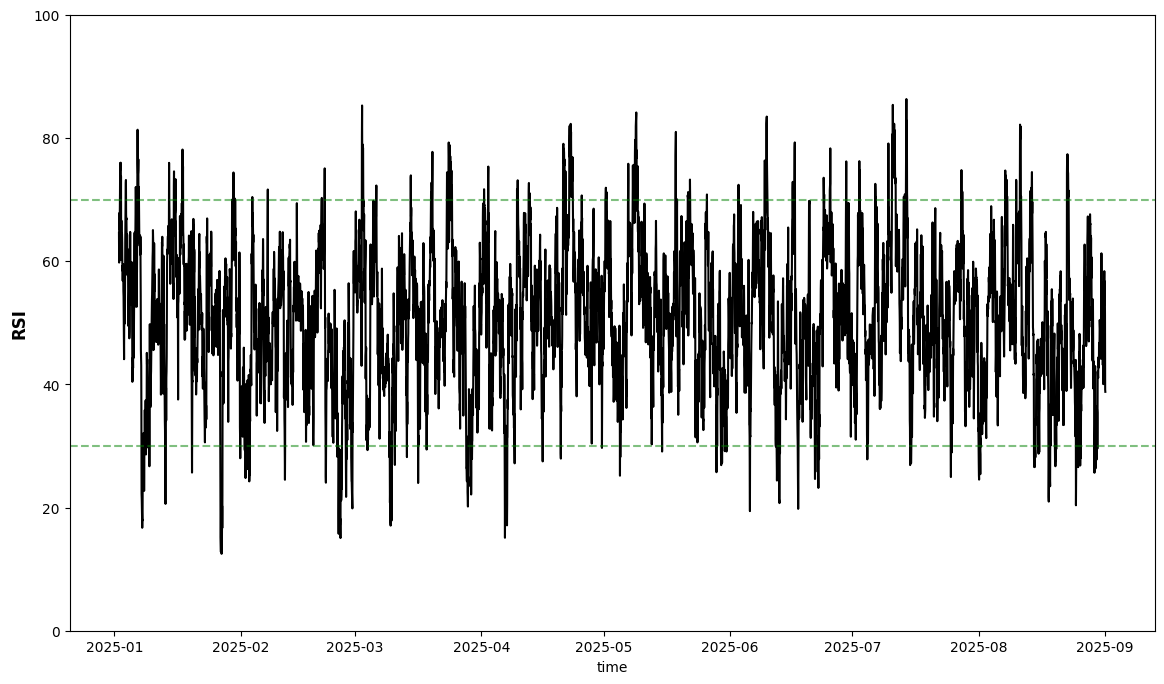

In [6]:
func.plot_rsi(df, param)

2. Bollinger Bands

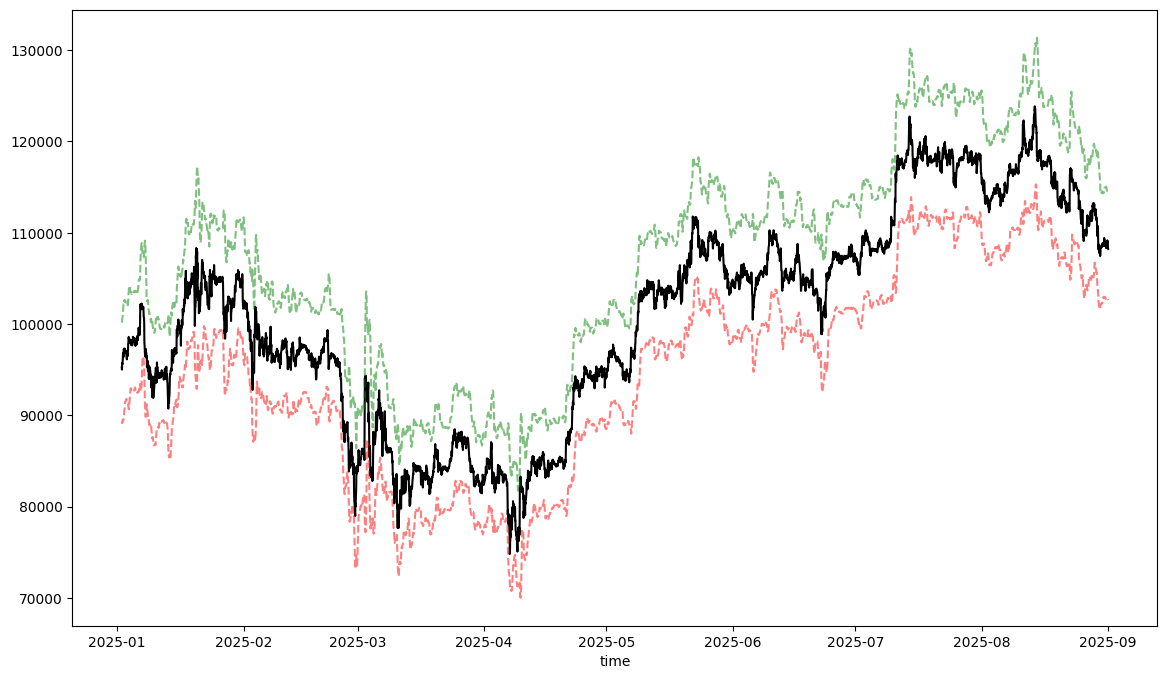

In [7]:
func.plot_bbands(df, param)

3. NAV vs Baseline (daily)

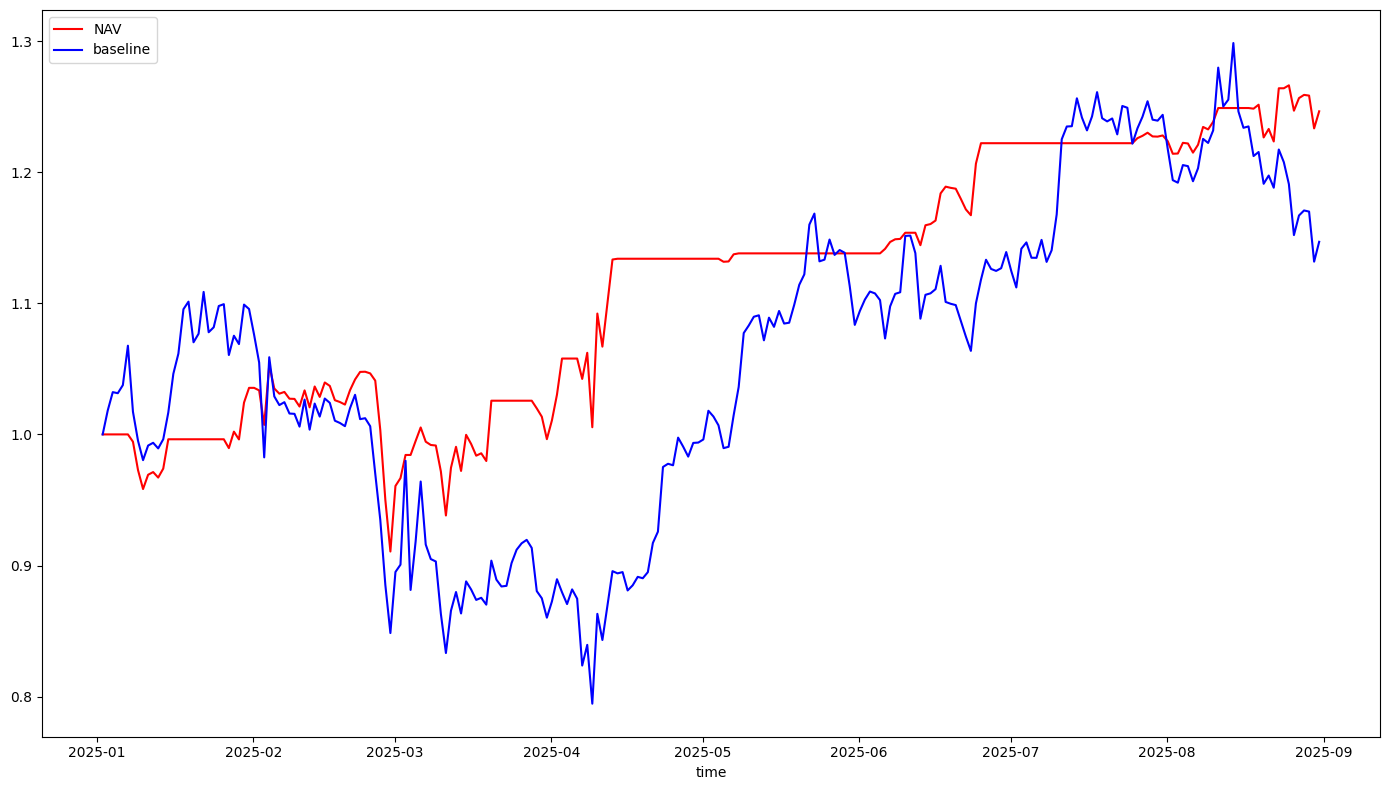

In [8]:
func.plot_nav(account_daily)

4. Mark trading points (hourly)

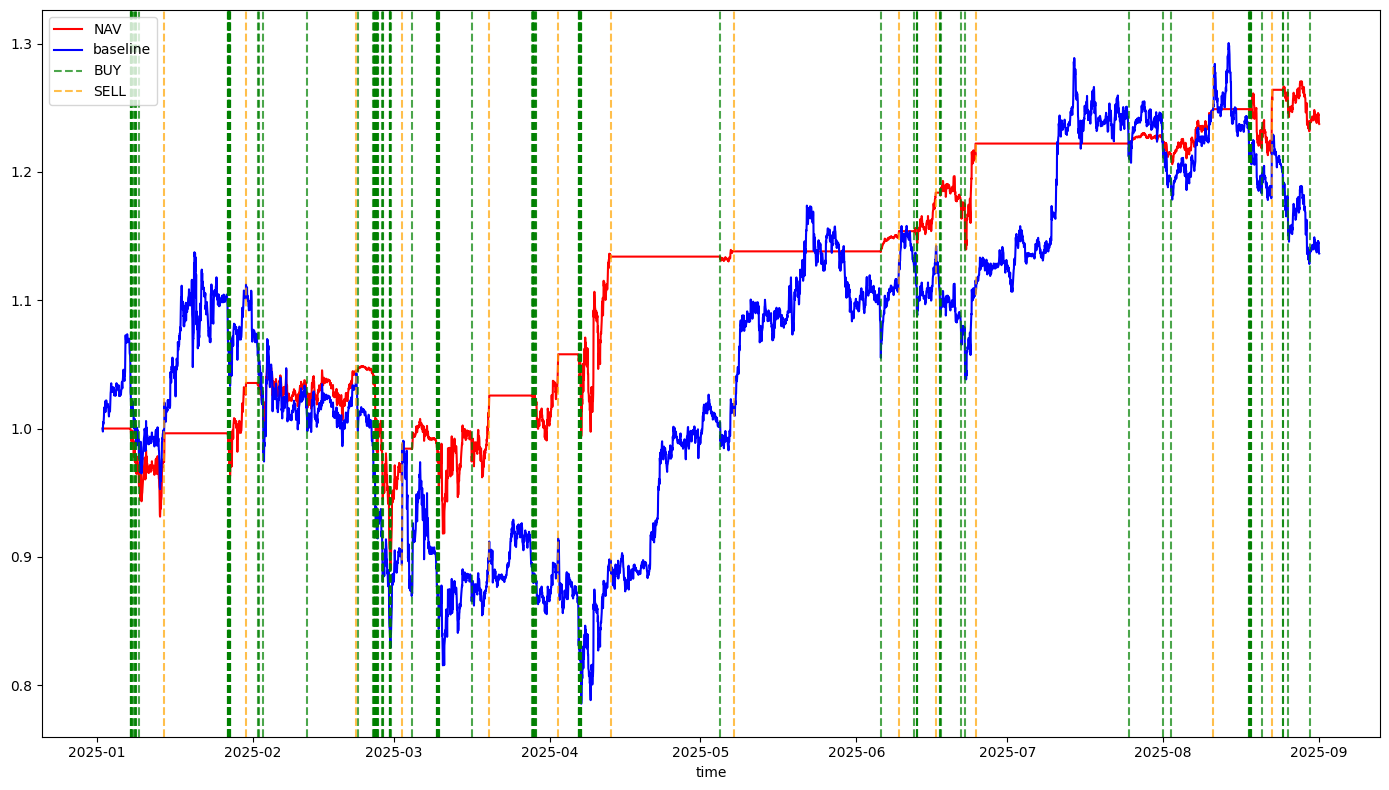

In [9]:
func.mark_trading(account_hourly, trades)